In [ ]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from lightgbm import LGBMRegressor as gbm
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
train_df = pd.read_csv("/content/train.csv", dtype={'id' : int, 'date' : object, 'store_nbr' : int, 'item_nbr' : int, 'unit_sales' : float, 'onpromotion' : object})
del train_df['id']

In [ ]:
stores_df = pd.read_csv("/content/stores.csv")
holidays_events_df = pd.read_csv("/content/holidays_events.csv")
items_df = pd.read_csv("/content/items.csv")
oil_df = pd.read_csv("/content/oil.csv")
transactions_df = pd.read_csv("/content/transactions.csv")

In [ ]:
# Subsetting data
data = train_df.loc[train_df['store_nbr'] == 3]

In [ ]:
del train_df

## Cross validation methods

In [ ]:
def cross_validation_method(df , method, test_start_date, train_size = 365*2, test_size = 15, cv_steps = 30, window_shift = 1):
    
    train_indices_list = []
    cv_indices_list = []

    if method == 'sliding':
        for step in range(cv_steps):
            train_start_date = (test_start_date - pd.Timedelta(train_size - step, 'days')).date()
            train_end_date = (test_start_date + pd.Timedelta(step - 1, 'days')).date()
            train_indices_list.append((train_start_date, train_end_date))

            cv_start_date = (test_start_date + pd.Timedelta(step, 'days')).date()
            cv_end_date = (test_start_date + pd.Timedelta(step + 14, 'days')).date()
            cv_indices_list.append((cv_start_date, cv_end_date))
            # print(train_start_date, ' to ', train_end_date, '-------', cv_start_date, ' to ', cv_end_date)
    
    elif method == 'expanding':
        for step in range(cv_steps):
            train_start_date = (test_start_date - pd.Timedelta(train_size, 'days')).date()
            train_end_date = (test_start_date + pd.Timedelta(step - 1, 'days')).date()
            train_indices_list.append((train_start_date, train_end_date))

            cv_start_date = (test_start_date + pd.Timedelta(step, 'days')).date()
            cv_end_date = (test_start_date + pd.Timedelta(step + 14, 'days')).date()
            cv_indices_list.append((cv_start_date, cv_end_date))
            # print(train_start_date, ' to ', train_end_date, '-------', cv_start_date, ' to ', cv_end_date)
    
    return train_indices_list, cv_indices_list 

In [ ]:
cross_validation_method(data , 
                        method = 'expanding', 
                        test_start_date = pd.datetime(2017,1,1), 
                        train_size = 365*3, 
                        test_size = 15, 
                        cv_steps = 30)

## Data Preprocessing

In [ ]:
def cartesian(df1, df2):
    """Determine Cartesian product of two data frames."""
    key = 'key'
    while key in df1.columns or key in df2.columns:
        key = '_' + key
    key_d = {key: 0}
    return pd.merge(
        df1.assign(**key_d), df2.assign(**key_d), on=key).drop(key, axis=1)

In [ ]:
def data_preprocessing(df, holidays_events_df, oil_df, item_df, lag_days = [1,7,30], rolling_days = [7,30,60]):

    # filter out items who has been sold for less than n days
    item_count = df.groupby('item_nbr')['unit_sales'].count()
    items_to_keep = item_count[item_count > 300].index
    # print(items_to_keep)
    df = df.loc[df['item_nbr'].isin(items_to_keep)]

    start_date = pd.to_datetime(df['date'].agg(['min', 'max'])['min'])
    end_date = pd.to_datetime(df['date'].agg(['min', 'max'])['max'])
    date_df = pd.DataFrame()
    date_df['date'] = pd.date_range(start=start_date, end= end_date)  
    date_df['date'] = pd.to_datetime(date_df['date'])
    unique_store_df = pd.DataFrame({'store_nbr' : df['store_nbr'].unique()})
    unique_item_df = pd.DataFrame({'item_nbr' : df['item_nbr'].unique()})
      
    date_df = cartesian(date_df, unique_store_df)
    date_df = cartesian(date_df, unique_item_df)

    df['date'] = pd.to_datetime(df['date'])
    df = date_df.merge(df, how = 'left', on = ['date', 'store_nbr', 'item_nbr'])

    # print(df.isna().sum())
    # print(len(df))

    # fill NA values of onpromotion and one-hot encoding
    df['onpromotion'] = df['onpromotion'].fillna("Not Mentioned")
    df_promo = pd.get_dummies(df['onpromotion'])
    df_promo = df_promo.drop(['Not Mentioned'], axis=1)
    df_promo = df_promo.rename(columns={'True': "promoted", 'False': "not_promoted"})
    df = pd.concat([df, df_promo], axis = 1)
    df = df.drop(['onpromotion'], axis=1)
    
    # create date features
    # df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = (df['day_of_week']>=5).astype(np.int8)

    # Handling nan values Unit sales 
    df['unit_sales'] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].ffill()
    df['unit_sales'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.fillna(x.mean()))
    # print(df.isna().sum())
    # create Lag features
    SHIFT = 15
    for l in lag_days:
        df['lag_{}'.format(l)] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].transform(lambda x: x.shift(SHIFT+l))
    # print(df.isna().sum())
    # Rolling features
    for r in rolling_days:
        df['rolling_mean_{}'.format(r)] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].transform(lambda x: x.shift(SHIFT).rolling(r, min_periods = 1).mean())
    # print(df.isna().sum())
    # merge oil_df
    oil_df['date'] = pd.to_datetime(oil_df['date'])
    oil_df = oil_df.rename(columns={"dcoilwtico": "oil_price"})
    df = df.merge(oil_df, how = 'left', on = 'date')
    
    # Filling the missing values of oil prices from the price of the previous row
    df['oil_price'] = df["oil_price"].fillna(axis = 0,method = 'ffill')
    # To fill the oil prices for first day, we will copy the mean price from the second day.
    oil_price = df[df.date == '2013-01-02']['oil_price']
    oil_price = round(np.mean(oil_price), 2)
    df['oil_price'] = df['oil_price'].fillna(oil_price)


    # merge holiday_df
    holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
    holidays_events_df['type'] = holidays_events_df['type'].replace(['Additional','Bridge','Event', 'Transfer'], 'Holiday')
    holidays_events_df = holidays_events_df.drop(['locale', 'locale_name','description','transferred'], axis=1)
    holidays_events_df = holidays_events_df.rename(columns={"type": "day_type"})
    df = df.merge(holidays_events_df[['date', 'day_type']], how = 'left', on = 'date')
    #df = df.drop(['type'], axis=1)
    df['day_type'].fillna(False, inplace = True)
    df['day_type'] = df['day_type'].astype(bool).astype(int)

    """
    # merge items to include item families and drop item number
    item_df = item_df[['item_nbr', 'family']]
    item_df['family'] = item_df['family'].replace(['HOME AND KITCHEN I','HOME AND KITCHEN II','CELEBRATION',
                                             'AUTOMOTIVE', 'LINGERIE', 'GROCERY II', 'SEAFOOD',
                                             'PLAYERS AND ELECTRONICS', 'LADIESWEAR', 'BEAUTY', 'PET SUPPLIES',
                                            'LAWN AND GARDEN', 'MAGAZINES', 'HARDWARE',
                                             'SCHOOL AND OFFICE SUPPLIES', 'HOME APPLIANCES', 'BABY CARE',
                                            'BOOKS'], 'Others')
    family_df = pd.get_dummies(item_df['family'])
    item_df = pd.concat([item_df, family_df], axis = 1)
    df = pd.merge(df, item_df, on = 'item_nbr', how = 'left')
    df = df.drop(['item_nbr', 'store_nbr', 'family'], axis=1)
    """
    # print(df.head())

    return df

In [ ]:
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])

## CV for LightGBM

In [ ]:
def model_CV(data, cv_method, cv_start_date, lgb_params, train_size = 365*2, test_size = 15, cv_steps = 5, window_shift = 1, lag_days = [1, 7, 14], rolling_days = [7, 30, 60]):

    train_indices_list, valid_indices_list = cross_validation_method(df, method= cv_method, test_start_date= cv_start_date, 
                                                                     train_size= train_size, cv_steps=cv_steps, window_shift=window_shift)
    
    features = df.columns[~df.columns.isin(['unit_sales', 'date'])]
    cat_features = ['item_nbr', 'promoted', 'not_promoted', 'day_of_month', 'day_of_week', 'month', 'year', 'day_of_month', 'day_of_year', 'is_weekend']
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df['name'] = features
    feature_importance_df['imp'] = 0
    fold = 0 

    avg_mape = 0 
    avg_wmape = 0
    for train_dates, valid_dates in tqdm(zip(train_indices_list, valid_indices_list)):
        train_date_range = (df['date'] >= pd.to_datetime(train_dates[0])) & (df['date'] <= pd.to_datetime(train_dates[1]))
        valid_date_range = (df['date'] >= pd.to_datetime(valid_dates[0])) & (df['date'] <= pd.to_datetime(valid_dates[1]))

        model = gbm(silent=True, verbose = -1)
        model.set_params(**lgb_params)
        model.fit(X = df.loc[train_date_range][features], y =  df[train_date_range]['unit_sales'],
                  categorical_feature = cat_features, 
                  eval_set = [(df[valid_date_range][features],df[valid_date_range]['unit_sales'] )], 
                  early_stopping_rounds = 2000,
                  eval_metric = 'mape',
                  verbose = False)
        # print(model.predict(df[valid_date_range][features]))
        pred_df = pd.DataFrame({'target' : df[valid_date_range]['unit_sales'],
                              'pred' : model.predict(df[valid_date_range][features])})
        
        pred_df['weight'] = pred_df['target']/ sum(pred_df['target'])
        pred_df['mape'] = abs(pred_df['target'] - pred_df['pred'])/pred_df['target']
        pred_df['wmape'] = pred_df['weight']*pred_df['mape']
        mape = pred_df['mape'].mean()
        wmape = pred_df['wmape'].sum()

        avg_mape += mape
        avg_wmape += wmape

        print(mape, wmape)
        
        feature_importance_df['imp'] += model.feature_importances_
        fold += 1
        # print(model.feature_importances_)
    
    # display(feature_importance_df.sort_values(by = 'imp', ascending = False))
    feature_importance_df['imp'] = feature_importance_df['imp']/fold    

    print(f"Average MAPE : {avg_mape/cv_steps}, Average WMAPE : {avg_wmape/cv_steps}")

    return pred_df,feature_importance_df, mape


In [ ]:
# Setting hyper parameters
lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 1000,
              'learning_rate': 0.1,
              'num_leaves': 127,
              'max_bin': 127,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }


# Preprocessing data
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])

# Cross validating model
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'sliding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*3, 
                           test_size = 15, 
                           cv_steps = 5, 
                           lag_days = [1, 2,3,4,5,6,7, 14, 30], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[119]	valid_0's mape: 0.475228
0.4763538446168485 0.44937254112234204
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[966]	valid_0's mape: 0.480465
0.48156142263204194 0.44908343650863947
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[142]	valid_0's mape: 0.482538
0.4839013917016424 0.4393986051299956
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[169]	valid_0's mape: 0.477702
0.4789055128299433 0.4276778629429606
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[142]	valid_0's mape: 0.47407
0.47546567003950263 0.4306911467392918
Average MAPE : 0.4792375683639958, Average WMAPE : 0.4392447184886459


In [ ]:
lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 100,
              'learning_rate': 0.1,
              'num_leaves': 127,
              'max_bin': 127,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }

df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'sliding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*3, 
                           test_size = 15, 
                           cv_steps = 30, 
                           lag_days = [1, 2,3,4,5,6,7, 14, 30], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[95]	valid_0's mape: 0.475712
0.47684130409602804 0.4530422612931215
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[84]	valid_0's mape: 0.481062
0.48214580416627584 0.4553582268875621
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[90]	valid_0's mape: 0.482643
0.4840038974761846 0.4415159075712213
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[92]	valid_0's mape: 0.477752
0.4789571877299317 0.42842223438539706
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[99]	valid_0's mape: 0.474707
0.4760800334926406 0.43359512171539055
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Bes

In [ ]:
lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 100,
              'learning_rate': 0.1,
              'num_leaves': 127,
              'max_bin': 127,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }

df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'expanding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*3, 
                           test_size = 15, 
                           cv_steps = 30, 
                           lag_days = [1, 2,3,4,5,6,7, 14, 30], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[95]	valid_0's mape: 0.475712
0.47684130409602804 0.4530422612931215
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[92]	valid_0's mape: 0.478434
0.4797009440289171 0.4501135004919937
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[81]	valid_0's mape: 0.479682
0.4809044611847878 0.43916267637789363
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[71]	valid_0's mape: 0.4821
0.4834685688676674 0.43109958612617627
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[79]	valid_0's mape: 0.473439
0.4747931285291205 0.4336978640301583
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best i

In [ ]:
# 5351 seconds

lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 500,
              'learning_rate': 0.1,
              'num_leaves': 127,
              'max_bin': 127,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }


# data = train_df.loc[train_df['store_nbr'].isin([3])]
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'sliding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*4, 
                           test_size = 15, 
                           cv_steps = 30, 
                           lag_days = [1, 7, 14], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[173]	valid_0's mape: 0.472441
0.4735170522121391 0.44250767360721643
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[387]	valid_0's mape: 0.478828
0.4800021661472242 0.4438639116163628
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[79]	valid_0's mape: 0.478647
0.47983382080235176 0.43579154806294285
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[134]	valid_0's mape: 0.478616
0.4797822022510807 0.42178814918147456
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[164]	valid_0's mape: 0.470845
0.4720135028074946 0.4247669932509011
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping.

In [ ]:
# 7771 seconds

lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 500,
              'learning_rate': 0.1,
              'num_leaves': 127,
              'max_bin': 127,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }


# data = train_df.loc[train_df['store_nbr'].isin([3])]
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'expanding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*4, 
                           test_size = 15, 
                           cv_steps = 30, 
                           lag_days = [1, 7, 14], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[173]	valid_0's mape: 0.472441
0.4735170522121391 0.44250767360721643
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[308]	valid_0's mape: 0.476853
0.47800104389117665 0.4395934058731341
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[119]	valid_0's mape: 0.478568
0.4797548383410306 0.4312701506477875
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[86]	valid_0's mape: 0.477744
0.4789967052765593 0.4235015093074327
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[316]	valid_0's mape: 0.46997
0.47127123457085435 0.4198893823880148
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. B

In [ ]:
# To calculate erroes based on pred_df returned dataframe from cross validation
pred_df['weight'] = pred_df['target']/ sum(pred_df['target'])
pred_df['mape'] = abs(pred_df['target'] - pred_df['pred'])/pred_df['target']
pred_df['wmape'] = pred_df['weight']*pred_df['mape']
mape = pred_df['mape'].mean()
wmape = pred_df['wmape'].sum()
print(mape, wmape)

## CV for Random Forest

In [ ]:
def model_CV_random_forest(data, cv_method, cv_start_date, params, train_size = 365*2, test_size = 15, cv_steps = 5, window_shift = 1, lag_days = [1, 7, 14], rolling_days = [7, 30, 60]):
    # df = data_preprocessing(data, holidays_events_df, oil_df, lag_days, rolling_days)
    # print(df.columns)
    train_indices_list, valid_indices_list = cross_validation_method(df, method= cv_method, test_start_date= cv_start_date, 
                                                                     train_size= train_size, cv_steps=cv_steps, window_shift=window_shift)
    # display(df)
    # print(train_indices_list, valid_indices_list)
    features = df.columns[~df.columns.isin(['unit_sales', 'date'])]
    cat_features = ['item_nbr', 'promoted', 'not_promoted', 'day_of_month', 'day_of_week', 'month', 'year', 'day_of_month', 'day_of_year', 'is_weekend']
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df['name'] = features
    feature_importance_df['imp'] = 0
    fold = 0 

    avg_mape = 0 
    avg_wmape = 0
    for train_dates, valid_dates in tqdm(zip(train_indices_list, valid_indices_list)):
        train_date_range = (df['date'] >= pd.to_datetime(train_dates[0])) & (df['date'] <= pd.to_datetime(train_dates[1]))
        valid_date_range = (df['date'] >= pd.to_datetime(valid_dates[0])) & (df['date'] <= pd.to_datetime(valid_dates[1]))

        model = RandomForestRegressor()
        model.set_params(**params)
        model.fit(X = df.loc[train_date_range][features], y =  df[train_date_range]['unit_sales'])
        #
        pred_df = pd.DataFrame({'target' : df[valid_date_range]['unit_sales'],
                              'pred' : model.predict(df[valid_date_range][features])})
        
        pred_df['weight'] = pred_df['target']/ sum(pred_df['target'])
        pred_df['mape'] = abs(pred_df['target'] - pred_df['pred'])/pred_df['target']
        pred_df['wmape'] = pred_df['weight']*pred_df['mape']
        mape = pred_df['mape'].mean()
        wmape = pred_df['wmape'].sum()

        avg_mape += mape
        avg_wmape += wmape

        print(mape, wmape)
        
        feature_importance_df['imp'] += model.feature_importances_
        fold += 1

    feature_importance_df['imp'] = feature_importance_df['imp']/fold    


    return pred_df,feature_importance_df, mape


In [ ]:
# 2384 seconds
ranfor_params = {
              'n_estimators': 100,
              'min_samples_leaf': 20,
              'max_features': 0.8,
              'max_samples': 0.8
                }


# data = train_df.loc[train_df['store_nbr'].isin([3])]
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV_random_forest(data, 
                           cv_method = 'sliding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           params = ranfor_params, 
                           train_size = 365*3, 
                           test_size = 15, 
                           cv_steps = 5, 
                           lag_days = [1, 2,3,4,5,6,7, 14, 30], 
                           rolling_days = [7, 30, 60]
                           )

In [ ]:
# 149 seconds
lgb_params = {'boosting_type': 'gbdt',
              'objective': 'mape',
              'n_estimators': 100,
              'learning_rate': 0.1,
              'min_sample_leaf': 20,
              'feature_fraction': 0.8,
              'bagging_fraction': 0.8,
              'verbose': -1
                }


# data = train_df.loc[train_df['store_nbr'].isin([3])]
df = data_preprocessing(data, holidays_events_df, oil_df,items_df, lag_days = [1, 7, 14], rolling_days =  [7, 30, 60])
df['unit_sales'] = abs(df['unit_sales'])
pred_df, fea_df, mape = model_CV(data, 
                           cv_method = 'sliding', 
                           cv_start_date = pd.datetime(2017,1,1), 
                           lgb_params = lgb_params, 
                           train_size = 365*3, 
                           test_size = 15, 
                           cv_steps = 5, 
                           lag_days = [1, 2,3,4,5,6,7, 14, 30], 
                           rolling_days = [7, 30, 60]
                           )

0it [00:00, ?it/s]

Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[96]	valid_0's mape: 0.473348
0.47433914737187177 0.45601284160435
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.480931
0.48203252246954964 0.4591532610384466
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[92]	valid_0's mape: 0.479972
0.4812345795458006 0.4440680897422298
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[82]	valid_0's mape: 0.478257
0.4794883012673893 0.43647840514301495
Training until validation scores don't improve for 2000 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's mape: 0.471512
0.4728235144187703 0.4335843961617067
Average MAPE : 0.4779836130146763, Average WMAPE : 0.4458593987379496


# EDA

In [ ]:
train_grp = train_df.groupby(by = ['date', 'store_nbr'])['unit_sales'].sum().reset_index()

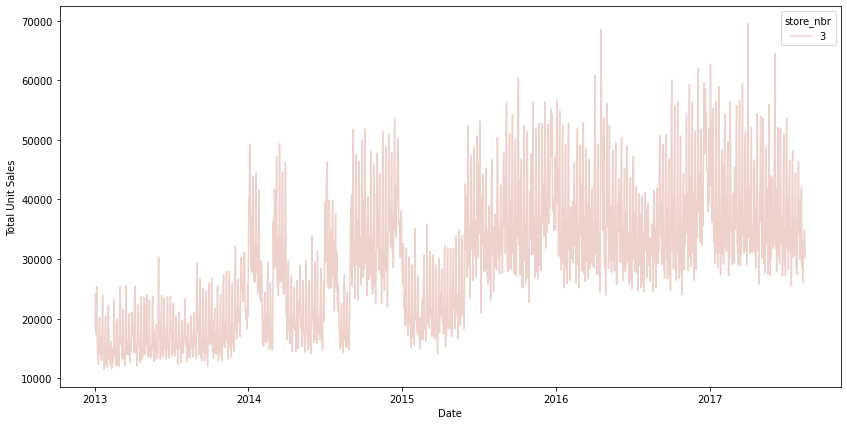

In [ ]:
plt.figure(figsize=(14,7))
sns.lineplot(x='date', y='unit_sales', data=train_grp.query("store_nbr == 3"), hue='store_nbr')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.show()

In [ ]:
store3 = train_grp.query("store_nbr == 3")[['date', 'unit_sales']].set_index('date')

<Figure size 720x720 with 0 Axes>

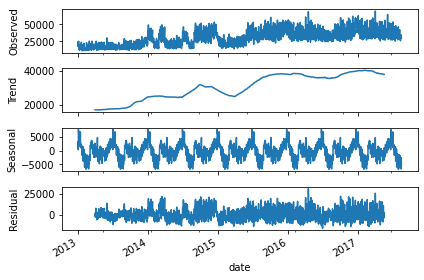

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize = (10,10))
res = seasonal_decompose(store3, model='additive', freq=180)
res.plot()
plt.show()

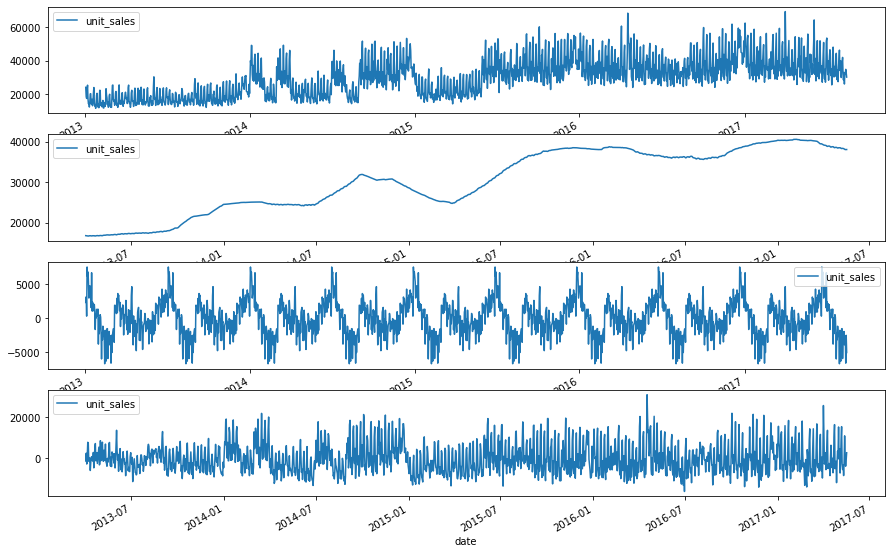

In [ ]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,10))
res.observed.plot(ax = ax1)
res.trend.plot(ax=ax2)
res.seasonal.plot(ax=ax3)
res.resid.plot(ax=ax4)